# 1. Imports and loading of necessary  files

In [1]:
import utils.dataset_functions as df
import utils.two_towers as ttn
import utils.metrics as mt
import torch
import numpy as np
from pathlib import Path
import pandas as pd

# df path
save_path = Path("results")
save_path.mkdir(parents=True, exist_ok=True)
song_embeds = Path("dataset") / "processed" / "song_subset.pt"

# Dimensions of the tower FFN
output_dim      = 16
hidden_dim      = 256
id_dim          = 16

# Load user data
user_item_data = pd.read_csv(Path("dataset") / "processed" / "merged.csv", index_col=False)

# Song embeddings
unique_songs = user_item_data[['item_id', 'normalized_embed']].drop_duplicates()
unique_songs["normalized_embed"] = unique_songs["normalized_embed"].apply(df.parse_embedding)

# User interactions
likes = pd.read_csv(Path("dataset") / "processed" / "likes.csv", usecols=['uid', 'timestamp', 'item_id']).drop_duplicates()
dislikes = pd.read_csv(Path("dataset") / "processed" / "dislikes.csv", usecols=['uid', 'timestamp', 'item_id']).drop_duplicates()


# Load our models
binary_model = ttn.DualAugmentedTwoTower("binary_label", hidden_dim, output_dim, id_dim)
binary_model.load(Path("models")/ "binary_label.pt")
non_binary_model = ttn.DualAugmentedTwoTower("continueous_label", hidden_dim, output_dim, id_dim)
non_binary_model.load(Path("models")/ "continueous_label.pt")

# Load test set:
samples = df.load_tensor_dataloader("test", Path("dataset")/"processed", 1, label_id=2)

# Songs is a pre-computed forward pass on all the songs for both 'binary' and 'continueous' models.
if song_embeds.exists():
    songs = torch.load(song_embeds, weights_only=False)  
else:
    songs = df.song_embeddings_pass_file(unique_songs, binary_model, non_binary_model)

binary_embeddings = songs['binary']
non_binary_embeddings = songs['continueous']

## Creating the model index

In [2]:
# Create the index for all song embeddings
non_binary_index = np.array([i.tolist() for i in non_binary_embeddings.values()])
binary_index = np.array([i.tolist() for i in binary_embeddings.values()])

non_binary_model.create_index(non_binary_index)
binary_model.create_index(binary_index)

## Determining the number of interactions each user had 

In [3]:
uids = []
interactions = []

user_item_data.groupby('uid')
likes.groupby('uid')
dislikes.groupby('uid')

for user in user_item_data['uid'].unique():

    uidata_subset = user_item_data[user_item_data['uid'] == user]

    likes_subset = likes[(likes['uid'] == user) & (likes['item_id'].isin(uidata_subset['item_id'].unique()))]
    dislikes_subset = dislikes[(dislikes['uid'] == user) & (dislikes['item_id'].isin(uidata_subset['item_id'].unique()))]

    ints = (len(likes_subset) + len(dislikes_subset))
    uids.append(user)
    interactions.append(ints)

interaction_count = pd.DataFrame({'uid' : uids, 'count': interactions})
interaction_count = interaction_count[interaction_count['count'] != 0].sort_values('count', ascending=False)
interaction_count

,uid,count
4663,4663,542
4089,4089,439
3098,3098,404
2834,2834,301
2740,2740,281
...,...,...
2736,2736,1
2,2,1
4783,4783,1
2688,2688,1


### For the top 200 most interactive users we save all the data we can find from the test set

In [4]:
num_users = 100

selected_users = interaction_count[:num_users]['uid'].to_list()
duplicates = 0 # For debug sake
users = {}
for user_features, song_embedding, label, interaction, user_id, song_id in samples.dataset:
    if user_id.item() in selected_users:
        if users.get(user_id.item()) is None:
            users[user_id.item()] = {}
            users[user_id.item()]['user_embed_bin'] = binary_model.user_pass(user_features.unsqueeze(0), user_id.unsqueeze(0)).detach().squeeze(0)
            users[user_id.item()]['user_embed_nbin'] = non_binary_model.user_pass(user_features.unsqueeze(0), user_id.unsqueeze(0)).detach().squeeze(0)
            users[user_id.item()]['song_data'] = {song_id.item(): (label.squeeze(0).tolist(), interaction.item())}

        
        else:
            if users[user_id.item()]['song_data'].get(song_id.item()) is not None:
                duplicates += 1
            users[user_id.item()]['song_data'][song_id.item()] = (label.squeeze(0).tolist(), interaction.item())


duplicates

20991

In [5]:
# Now, for each user we make a recommendation of size 'num_rec'. And we score these recommendations using the dot product.

# If a song from the recommendation was ALSO in our test set, we overwrite the base label and interection, 
# which was set at -1 and 0 resprectively as that indicates whether this user has any history with the recommended song.   


# Number of recommendations to make
num_rec = 3000

total_users = []
total_nbin_song_ids = []
total_nbin_distances = []
total_nbin_score = []
total_nbin_labels = []
total_nbin_interactions = []

total_bin_song_ids = []
total_bin_distances = []
total_bin_score = []
total_bin_labels = []
total_bin_interactions = []



for u in users.keys():

    user = users[u]

    # 1. Make binary and non-binary recommendations.
    nbin_query = user["user_embed_nbin"][np.newaxis, :]
    nbin_distances, nbin_indices = non_binary_model.recommendations(nbin_query, num_rec)

    bin_query = user["user_embed_bin"][np.newaxis, :]
    bin_distances, bin_indices = binary_model.recommendations(bin_query, num_rec)

    
    # 2. Score them and init the label and interaction lists
    nbin_score  = [(nbin_query * non_binary_embeddings[e]).sum().item() for e in nbin_indices]
    nbin_labels = [-1 for _ in range(num_rec)]
    nbin_interactions = [0 for _ in range(num_rec)]

 
    bin_score = [(bin_query * binary_embeddings[e]).sum().item() for e in bin_indices]
    bin_labels = [-1 for _ in range(num_rec)]
    bin_interactions = [0 for _ in range(num_rec)]

   

    
    # 3. Now for both binary and non_binary, check whether each song_id check if it has been listened to before in the test set and overwrite the label and interaction with actual values.
    for i in range(len(nbin_indices)):
        song_id = nbin_indices[i]
        song_data = user["song_data"].get(song_id) 
        
        if song_data is not None:
            nbin_labels[i] = song_data[0][1]
            nbin_interactions[i] = song_data[1]

    
    for i in range(len(bin_indices)):
        song_id = bin_indices[i]
        song_data = user["song_data"].get(song_id) 
        if song_data is not None:
            bin_labels[i] = song_data[0][0]
            bin_interactions[i] = song_data[1]






    # Add the total together for our dataframes
    total_users += [u for _ in range(len(bin_indices))]
    total_nbin_song_ids += nbin_indices
    total_nbin_distances += nbin_distances
    total_nbin_score += nbin_score
    total_nbin_labels += nbin_labels
    total_nbin_interactions += nbin_interactions

    total_bin_song_ids += bin_indices
    total_bin_distances += bin_distances
    total_bin_score += bin_score
    total_bin_labels += bin_labels
    total_bin_interactions += bin_interactions
    

### Save our final recommendations to dataframes and csv's.

In [6]:
bin_df = pd.DataFrame(
            data = {"uid": total_users,
                    "song_id": total_bin_song_ids,
                    "distances": total_bin_distances,
                    "score": total_bin_score,
                    "label": total_bin_labels,
                    "interaction": total_bin_song_ids
            })

nbin_df = pd.DataFrame(
            data = {"uid": total_users,
                    "song_id": total_nbin_song_ids,
                    "distances": total_nbin_distances,
                    "score": total_nbin_score,
                    "label": total_nbin_labels,
                    "interaction": total_nbin_interactions
            })
# Save our df's
bin_df.to_csv(save_path / "bin_df.csv", index=False)
nbin_df.to_csv(save_path/ "nbin_df.csv", index=False)

In [7]:
# If necessary
bin_df = pd.read_csv(save_path / "bin_df.csv", index_col=False)
nbin_df= pd.read_csv(save_path/ "nbin_df.csv", index_col=False)

### Drop the columns containing new recommendations (thus label = -1)

In [8]:
bin_df

,uid,song_id,distances,score,label,interaction
0,3748,2605,5.763488,1.477561,-1.0,2605
1,3748,2019,5.770164,1.577230,-1.0,2019
2,3748,2657,5.840607,1.461334,-1.0,2657
3,3748,2063,5.925749,1.376766,-1.0,2063
4,3748,18,6.003081,1.506880,-1.0,18
...,...,...,...,...,...,...
146995,4944,1422,6.831151,-0.335372,-1.0,1422
146996,4944,2858,6.832128,-0.551393,-1.0,2858
146997,4944,1327,6.835319,-0.690194,-1.0,1327
146998,4944,1837,6.845834,-0.250729,-1.0,1837


In [9]:
bin_df = bin_df[bin_df['label'] != -1]
nbin_df = nbin_df[nbin_df['label'] != -1]

## Make the rankings and score using our metrics

In [10]:
bin_rankings = []
nbin_rankings = []

for u in bin_df['uid'].unique():
    temp = bin_df[bin_df['uid'] == u].sort_values('score', ascending=False)
    if len(temp)>= 20: # Users have to have at minimum the max k we take defined in 'ks' (cell below)
        bin_rankings.append(temp['label'].to_list())

for u in nbin_df['uid'].unique():
    temp = nbin_df[nbin_df['uid'] == u].sort_values('score', ascending=False)
    if len(temp)>= 20: # Users have to have at minimum the max k we take defined in 'ks' (cell below)
        nbin_rankings.append(temp['label'].to_list())

ks = [5, 10, 15, 20]

bin_ndcg = []
bin_precision = []
bin_recall = []
bin_f1 = []
bin_avg_precision  = []

for val in bin_rankings:
    ndcg, precision, recall, f1, aprecision = mt.metrics(np.array(val), ks)
    bin_ndcg.append(ndcg)
    bin_precision.append(precision)
    bin_recall.append(recall)
    bin_f1.append(f1)
    bin_avg_precision.append(aprecision)
    
nbin_ndcg = []
nbin_precision = []
nbin_recall = []
nbin_f1 = []
nbin_avg_precision  = []

for val in nbin_rankings:
    ndcg, precision, recall, f1, aprecision = mt.metrics(np.array(val), ks)

    nbin_ndcg.append(ndcg)
    nbin_precision.append(precision)
    nbin_recall.append(recall)
    nbin_f1.append(f1)
    nbin_avg_precision.append(aprecision)
    

In [11]:
# Number of users left after the filtering
print(len(bin_rankings))
print(len(nbin_rankings))

49
49


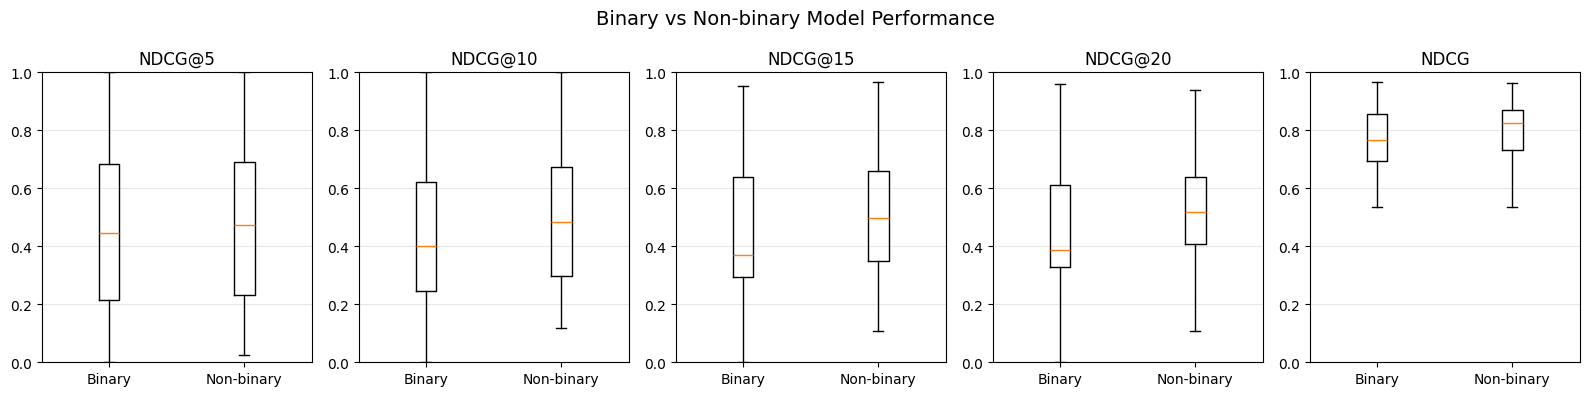

<Figure size 640x480 with 0 Axes>

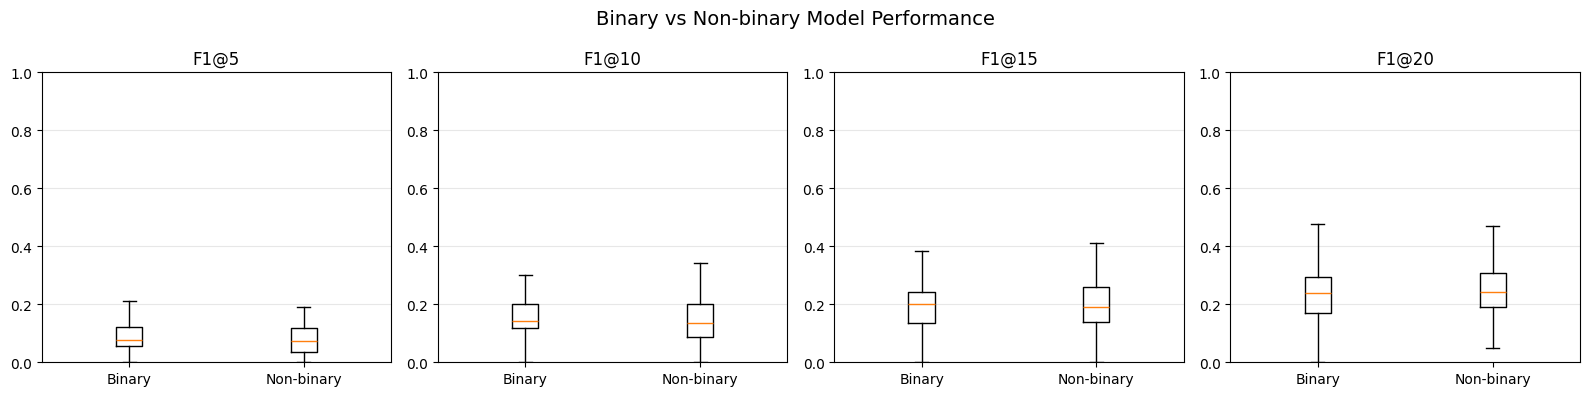

<Figure size 640x480 with 0 Axes>

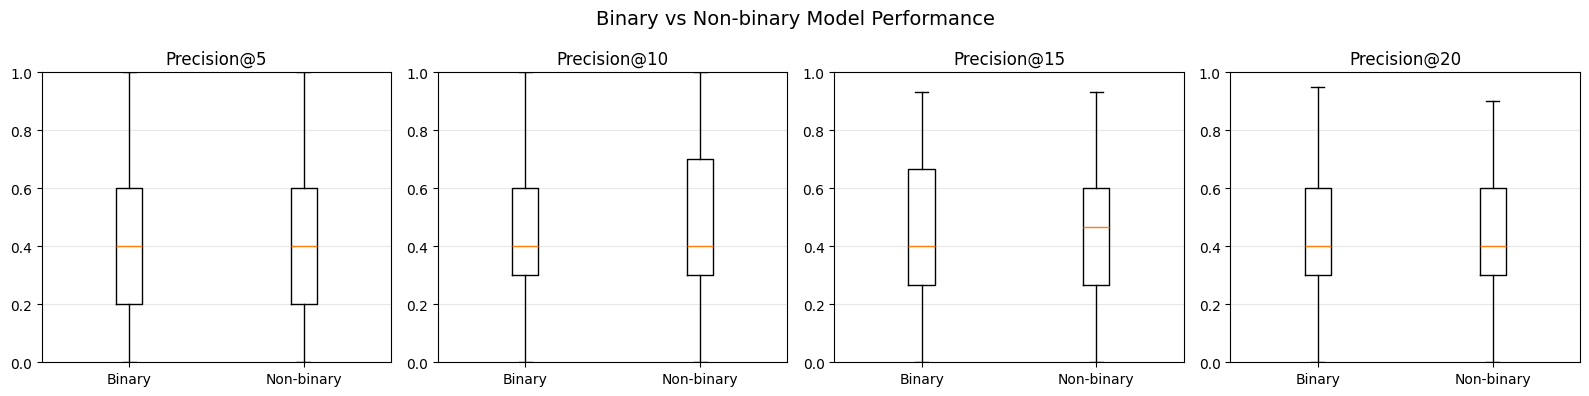

<Figure size 640x480 with 0 Axes>

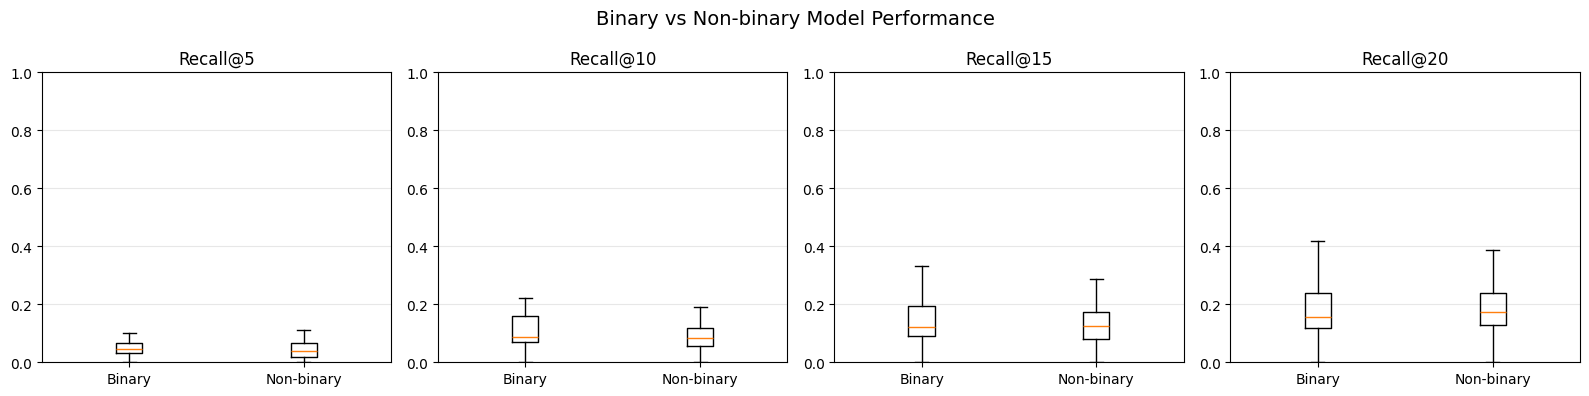

<Figure size 640x480 with 0 Axes>

In [12]:
# Plot our metrics.
mt.plot(1, 5, np.array(bin_ndcg), np.array(nbin_ndcg), [f"NDCG@{k}" for k in ks] + ["NDCG"], "NDCG")
mt.plot(1, 4, np.array(bin_f1), np.array(nbin_f1), [f"F1@{k}" for k in ks], "F1")
mt.plot(1, 4, np.array(bin_precision), np.array(nbin_precision), [f"Precision@{k}" for k in ks], "p")
mt.plot(1, 4, np.array(bin_recall), np.array(nbin_recall), [f"Recall@{k}" for k in ks], "r")